In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data Preprocessing

In [2]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
num_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

#### Train - Test split
Having trained basic classification models and built-in ensemble models, in this run building a custom ensemble model to leverage the diversity of wide range of classification models. Unlike the popular ensemble models like Random Forest which uses a bagging method, XGBoost, CatBoost, LGBM which uses boosting method, our custom model uses another ensemble technique called stacking along with bagging.

In [3]:
#bar_chart(data, 'education', 'y', 'no')

In [4]:
# data.to_csv('data.csv')

In [5]:
data = pd.read_csv('data.csv')

In [6]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data.y.values, stratify=data.y, test_size=0.2, random_state=10)

print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ",X_test.shape, y_test.shape)

Train data shape:  (32592, 18) (32592,)
Test data shape:  (8148, 18) (8148,)


In [8]:
pd.concat([X_test.reset_index(drop=True), pd.DataFrame(y_test, columns=['y'])], axis=1).to_csv('test.csv', index=None)

In [9]:
# split the train data set into D1 and D2
X_d1, X_d2, y_d1, y_d2 = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5, random_state=10)

print("D1 data set shape: ", X_d1.shape, y_d1.shape)
print("D2 data set shape: ",X_d2.shape, y_d2.shape)

D1 data set shape:  (16296, 18) (16296,)
D2 data set shape:  (16296, 18) (16296,)


In [10]:
print("Number of negative and positive data points in D1 (X_d1): ", np.unique(y_d1, return_counts=True))
print("Number of negative and positive data points in D2 (X_d2): ", np.unique(y_d2, return_counts=True))

Number of negative and positive data points in D1 (X_d1):  (array([0, 1]), array([14453,  1843]))
Number of negative and positive data points in D2 (X_d2):  (array([0, 1]), array([14452,  1844]))


#### Data transformation

##### Numerical features scaling

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(X_d1[num_features])

In [12]:
# provide a replacement for pickle to work efficiently on arbitrary Python objects containing large data, in particular large numpy arrays
joblib.dump(scaler, 'num_features_scaler.pkl')

['num_features_scaler.pkl']

In [13]:
# creating new empty dataframes to store processed data for training
X_d1_processed = X_d1.drop(cat_features, axis=1)
X_d2_processed = X_d2.drop(cat_features, axis=1)
X_test_processed = X_test.drop(cat_features, axis=1)
X_d1_processed.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'nr.employed'],
      dtype='object')

In [14]:
X_d1_processed.reset_index(drop=True, inplace=True)
X_d2_processed.reset_index(drop=True, inplace=True)
X_test_processed.reset_index(drop=True, inplace=True)

In [15]:
# transform all numerical features and save it new dataframes
X_d1_processed[num_features] = scaler.transform(X_d1[num_features])
X_d2_processed[num_features] = scaler.transform(X_d2[num_features])
X_test_processed[num_features] = scaler.transform(X_test[num_features])

##### Categorical feature tranformation

* We will tranform categorical features using onehot encoder

In [16]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')
cat_features_ohe = onehotencoder.fit(X_d1[cat_features])

In [17]:
joblib.dump(cat_features_ohe, 'cat_features_ohe.pkl')

['cat_features_ohe.pkl']

In [18]:
X_d1_ohe = cat_features_ohe.transform(X_d1[cat_features])
X_d2_ohe = cat_features_ohe.transform(X_d2[cat_features])
X_test_ohe = cat_features_ohe.transform(X_test[cat_features])

In [19]:
X_d1_ohe.toarray().shape

(16296, 52)

In [20]:
cat_feature_labels_ohe = np.concatenate(cat_features_ohe.categories_).ravel().tolist()

In [21]:
X_d1_ohe = pd.DataFrame(X_d1_ohe.toarray(), columns=cat_feature_labels_ohe)
X_d2_ohe = pd.DataFrame(X_d2_ohe.toarray(), columns=cat_feature_labels_ohe)
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=cat_feature_labels_ohe)

In [22]:
print("shape of categorical features of D1, D2 and test sets after converting categorical features with one hot encoding:")
X_d1_ohe.shape, X_d2_ohe.shape, X_test_ohe.shape

shape of categorical features of D1, D2 and test sets after converting categorical features with one hot encoding:


((16296, 52), (16296, 52), (8148, 52))

##### Merging transformed numerical features and categorical features

In [23]:
X_d1_final = pd.concat([X_d1_ohe, X_d1_processed], axis=1)
X_d2_final = pd.concat([X_d2_ohe, X_d2_processed], axis=1)
X_test_final = pd.concat([X_test_ohe, X_test_processed], axis=1)

# X_d1_final.drop('Unnamed: 0', axis=1, inplace=True)
# X_d2_final.drop('Unnamed: 0', axis=1, inplace=True)
# X_test_final.drop('Unnamed: 0', axis=1, inplace=True)

print("Final processed D1, D2 data and test data shapes: ")
print(X_d1_final.shape, X_d2_final.shape, X_test_final.shape)

Final processed D1, D2 data and test data shapes: 
(16296, 60) (16296, 60) (8148, 60)


## Modeling

In [24]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 47.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached plotly-5.18.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached tenacity-8.2.3-py3-none-any.whl.metadata (1.0 kB)
Using cached plotly-5.18.0-py3-none-any.whl (15.6 MB)
Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for catboost (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-311
      creating build/lib.macosx-10.9-x86_64-cpython-311/catboost
      copying catboost/monoforest.py -> build/lib.macosx-10.9-x86_64-cpython-311/catboost
      copying catboos

In [25]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix
#from scikitplot.metrics import plot_cumulative_gain
import joblib

In [26]:
def print_confusion_matrix_accuracy(model, X_test, y_true):
    # print confusion matrix
    y_pred = model.predict(X_test)
    confusion_matrix_test = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix_test.flatten()
    accuracy = (tp + tn)/ (tn + fp + fn + tp)
    print("Model Accuracy: ", accuracy)
    
    # code reference - https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix_test.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix_test.flatten()/np.sum(confusion_matrix_test)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix_test, annot=labels, fmt='', cmap='Greens')
    plt.title("Confusion Matrix for Test Data")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
        
    return y_pred, accuracy, tn, fp, fn, tp


In [27]:
def plot_auc(model, X_train, X_test, y_train, y_test):
    # AUC
    y_train_pred_prob = model.predict_proba(X_train) # taking only predictions for positive class
    y_test_pred_prob = model.predict_proba(X_test) # taking only predictions for positive class

    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred_prob[:, 1])
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred_prob[:, 1])

    plt.plot(train_fpr, train_tpr, label='Train AUC:'+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label='Test AUC:'+str(auc(test_fpr, test_tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC curve for train and test sets')
    plt.legend()
    plt.grid()
    plt.show()

    return y_train_pred_prob, y_test_pred_prob, auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)

In [28]:
def precision_recall_f1(y_test, y_pred):
    precision, recall, f1_beta, support = precision_recall_fscore_support(y_test, y_pred) #, average='micro'
    print('Precision Score for class-0:', precision[0], 'and class-1: ', precision[1])
    print('-'*100)
    print('Recall Score for class-0:', recall[0], 'and class-1:', recall[1])
    print('-'*100)
    print('F1 Score for class-0:', f1_beta[0], 'and class-1:', f1_beta[1])
    # print('Support: ', support)
    return precision, recall, f1_beta

In [123]:
def plot_gain_curve(y_true, y_pred_prob, x, y):
    plot_cumulative_gain(y_true, y_pred_prob)
    plt.vlines(x=x, ymax=1, ymin=0, colors='g', linestyles='--')
    plt.hlines(y=y, xmax=0.9, xmin=0, colors='g', linestyles='--')
    # plt.grid()
    plt.show()
    
    # plot_lift_curve(y_test, y_test_pred_prob)

In [29]:
def get_lift_index(y_true, y_pred_prob):
    decile_df = pd.DataFrame(list(zip(y_true, y_pred_prob[:, 1])), columns=['y_true','y_pred'])
    decile_df['decile'] = pd.qcut(decile_df.y_pred, 10, duplicates='drop') #, duplicates='drop'  labels=np.arange(10,0,-1),
    lift_df = decile_df.groupby('decile')['y_pred'].count().reset_index()
    lift_df.rename({'y_pred':'total'}, axis=1, inplace=True)
    lift_df_pred = decile_df[decile_df.y_true==1].groupby('decile')['y_true'].count().reset_index()
    lift_df_final = lift_df.merge(lift_df_pred, on='decile')
    lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

    lift_df_final['decile'] = [(i+1) for i in range(len(lift_df_final.decile.unique()))]
    
    # calculate the weighted lift index value
    w = 1 # initializing the weight to 1
    lift_index = 0.0
    for cnt in lift_df_final.y_true.values:
        lift_index += cnt * w
        w = w - 0.1
    
    lift_index = lift_index/lift_df_final.y_true.sum()
    return lift_index

### Genrating samples with replacement from D1 (X_d1)

In [30]:
def create_sample(inputs, labels):
    """ Function takes input data and target data, select the random samples by sampling with replacement technique 
    from both the datasets and returns the samples """
    
    # number of data points in input data set
    rows = len(inputs)
    # print(rows)
    # select 70% of the rows for each sample
    sample_size = round(rows * 70 / 100)
    # get the indexes of the samples
    sampled_rows = np.random.choice(rows, sample_size, replace=True)
    # print(len(sampled_rows))
    
    # print(sampled_rows[:, None])
    # make the sample for input data and label data with the sampled row indexes
    input_sample = inputs.iloc[sampled_rows]
    labels_sample = labels[sampled_rows]
    
    # print(input_sample.shape, labels_sample.shape)
    return input_sample, labels_sample

In [31]:
def get_samples(X, y, n_samples):
    """ Thi function takes the input data set and target dataset and number of sampes as input and generates the 
    samples and returns a list of generated samples """
    
    # initiate the two lists to store the samples and their targets
    list_input_data = []
    list_target_data = []
    
    for i in range(n_samples):
        # generate n_samples by calling create_sample function and save samples to lists
        input_sample, labels_sample = create_sample(X, y)
        list_input_data.append(input_sample)
        list_target_data.append(labels_sample)
    
    # return the list of generated samples and targets 
    return list_input_data, list_target_data

In [150]:
# K= 100 70% of data in 100 bucket with sampling with replacement

In [33]:
meta_metrics = dict()
meta_metrics['LGBM'] = dict()
meta_metrics['CAT'] = dict()
meta_metrics 


{'LGBM': {}, 'CAT': {}}

In [45]:
# create k=50, 100, 150, 200 samples from D1
k = 100
list_input_data, list_target_data = get_samples(X_d1_final, y_d1, k)


In [46]:
len(list_input_data), len(list_target_data)




(100, 100)

In [47]:
list_input_data[1]

,admin.,blue-collar,entrepreneur,housemaid,job_unknown,management,retired,self-employed,services,student,...,nonexistent,success,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed
14558,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.376062,-0.804779,-0.201157,0.198372,-0.354026,0.723121,0.870077,0.333879
8572,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.872888,-0.690314,-0.693876,0.198372,-0.354026,0.723121,0.870077,0.333879
15958,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.833618,0.021005,0.784280,0.198372,-0.354026,-1.063012,-0.077013,-1.251595
2511,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.087843,0.135470,-0.201157,0.198372,-0.354026,-0.652427,-0.335310,0.400171
8472,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.279989,1.394586,-0.693876,0.198372,-0.354026,0.591456,-0.485984,0.846258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.584669,-0.698490,0.291561,0.198372,-0.354026,0.591456,-0.485984,0.846258
3013,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.087843,-0.898804,0.291561,0.198372,-0.354026,1.539094,-0.292261,0.846258
10446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.200376,3.871937,-0.693876,0.198372,-0.354026,0.723121,0.870077,0.333879
5711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-0.664281,0.875405,-0.693876,0.198372,1.649169,0.828799,0.138235,-2.419984


In [149]:
list_input_data

[       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
 3610      1.0          0.0           0.0        0.0          0.0         0.0   
 6240      0.0          0.0           0.0        0.0          0.0         0.0   
 4724      0.0          1.0           0.0        0.0          0.0         0.0   
 12274     0.0          0.0           0.0        0.0          0.0         0.0   
 9456      1.0          0.0           0.0        0.0          0.0         0.0   
 ...       ...          ...           ...        ...          ...         ...   
 412       0.0          0.0           0.0        0.0          0.0         0.0   
 6044      0.0          0.0           0.0        0.0          0.0         1.0   
 12211     0.0          0.0           0.0        0.0          0.0         0.0   
 7209      0.0          1.0           0.0        0.0          0.0         0.0   
 10446     0.0          0.0           0.0        0.0          0.0         0.0   
 
        retired  self-empl

### Training base models on samples

* Based on the performance of the models with hyper parameter tuning, I have chosen the below models

In [48]:
list_classifiers = [LogisticRegression(class_weight='balanced', random_state=10, max_iter=1000),
                    SVC(probability=True, class_weight='balanced', random_state=10),
                    DecisionTreeClassifier(class_weight='balanced', random_state=10),
                    RandomForestClassifier(class_weight='balanced', random_state=10),
                    #CatBoostClassifier(class_weights=[0.13, 0.87], random_state=10, silent=True),
                    #LGBMClassifier(class_weight='balanced', random_state=10)
                    ]

In [49]:
# pick any classification model from the above list and train a model on given sample dataset
# initialize a list to store all trained models
list_models = []
for i in tqdm(range(k)):
    # generate random number and get a classifier randomly from list_classifiers
    idx = np.random.randint(0, len(list_classifiers))
    clf = list_classifiers[idx]
    # train a model with ith sample as input and target
    #print(list_input_data[i])
    clf.fit(list_input_data[i], list_target_data[i])
    list_models.append(clf)
    # print(list_models)

  1%|          | 1/100 [00:00<00:14,  6.75it/s]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
11812     0.0          0.0           0.0        0.0          0.0         0.0   
15059     0.0          0.0           0.0        0.0          0.0         0.0   
16079     0.0          0.0           0.0        1.0          0.0         0.0   
14650     0.0          0.0           0.0        0.0          0.0         0.0   
3153      0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
15907     0.0          0.0           1.0        0.0          0.0         0.0   
1059      0.0          0.0           0.0        0.0          0.0         0.0   
15034     0.0          0.0           0.0        0.0          0.0         0.0   
7272      0.0          0.0           1.0        0.0          0.0         0.0   
9473      0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

  4%|▍         | 4/100 [00:13<04:42,  2.94s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
12129     1.0          0.0           0.0        0.0          0.0         0.0   
15956     0.0          0.0           0.0        1.0          0.0         0.0   
15750     1.0          0.0           0.0        0.0          0.0         0.0   
15243     0.0          0.0           1.0        0.0          0.0         0.0   
12148     0.0          0.0           0.0        0.0          0.0         1.0   
...       ...          ...           ...        ...          ...         ...   
764       0.0          1.0           0.0        0.0          0.0         0.0   
12688     1.0          0.0           0.0        0.0          0.0         0.0   
3678      0.0          0.0           0.0        0.0          0.0         0.0   
16160     0.0          1.0           0.0        0.0          0.0         0.0   
6804      1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

  6%|▌         | 6/100 [00:26<07:27,  4.77s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
9551      0.0          1.0           0.0        0.0          0.0         0.0   
3127      0.0          0.0           0.0        1.0          0.0         0.0   
8762      0.0          0.0           0.0        0.0          1.0         0.0   
12918     1.0          0.0           0.0        0.0          0.0         0.0   
1531      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
5699      0.0          0.0           0.0        0.0          0.0         0.0   
7388      0.0          0.0           0.0        0.0          0.0         1.0   
7632      0.0          0.0           0.0        0.0          0.0         0.0   
3078      0.0          0.0           0.0        0.0          0.0         0.0   
11664     0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

  7%|▋         | 7/100 [00:27<05:45,  3.71s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
1344      0.0          0.0           0.0        0.0          0.0         0.0   
12275     0.0          0.0           0.0        0.0          0.0         1.0   
3917      0.0          0.0           0.0        1.0          0.0         0.0   
8139      0.0          0.0           0.0        0.0          0.0         0.0   
3788      0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
8536      0.0          0.0           0.0        0.0          0.0         0.0   
7030      0.0          0.0           0.0        1.0          0.0         0.0   
13907     0.0          0.0           1.0        0.0          0.0         0.0   
3786      0.0          0.0           0.0        0.0          0.0         0.0   
3469      1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 10%|█         | 10/100 [00:40<05:20,  3.56s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
16191     0.0          0.0           0.0        0.0          0.0         1.0   
10289     0.0          0.0           0.0        0.0          0.0         0.0   
6909      0.0          1.0           0.0        0.0          0.0         0.0   
5106      0.0          0.0           1.0        0.0          0.0         0.0   
12514     1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
15036     0.0          0.0           0.0        0.0          0.0         0.0   
10152     0.0          0.0           0.0        0.0          0.0         0.0   
13789     1.0          0.0           0.0        0.0          0.0         0.0   
7172      0.0          0.0           0.0        0.0          0.0         0.0   
15687     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 12%|█▏        | 12/100 [00:53<06:43,  4.58s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
2703      0.0          0.0           0.0        0.0          0.0         1.0   
395       0.0          0.0           0.0        0.0          0.0         0.0   
9707      1.0          0.0           0.0        0.0          0.0         0.0   
14573     0.0          1.0           0.0        0.0          0.0         0.0   
6765      0.0          0.0           1.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
10115     0.0          0.0           0.0        0.0          0.0         0.0   
3702      0.0          0.0           0.0        0.0          0.0         0.0   
2807      0.0          0.0           0.0        0.0          0.0         1.0   
12907     0.0          1.0           0.0        0.0          0.0         0.0   
13518     1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 16%|█▌        | 16/100 [01:06<05:12,  3.72s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
12948     0.0          0.0           0.0        0.0          0.0         1.0   
8108      1.0          0.0           0.0        0.0          0.0         0.0   
14946     0.0          0.0           0.0        0.0          0.0         0.0   
3329      0.0          0.0           0.0        0.0          0.0         1.0   
15873     0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
2558      0.0          0.0           1.0        0.0          0.0         0.0   
3648      0.0          0.0           0.0        0.0          0.0         0.0   
12736     1.0          0.0           0.0        0.0          0.0         0.0   
12930     0.0          1.0           0.0        0.0          0.0         0.0   
14284     0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 18%|█▊        | 18/100 [01:20<06:01,  4.41s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
6679      0.0          0.0           1.0        0.0          0.0         0.0   
5363      0.0          0.0           0.0        0.0          0.0         0.0   
6898      0.0          0.0           0.0        0.0          0.0         0.0   
15655     0.0          0.0           0.0        0.0          1.0         0.0   
3195      0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
5125      0.0          0.0           0.0        0.0          0.0         0.0   
7328      0.0          0.0           0.0        0.0          0.0         0.0   
7514      1.0          0.0           0.0        0.0          0.0         0.0   
10963     1.0          0.0           0.0        0.0          0.0         0.0   
3223      0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 19%|█▉        | 19/100 [01:33<08:47,  6.51s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
11048     0.0          0.0           0.0        0.0          0.0         0.0   
12468     0.0          0.0           0.0        0.0          0.0         0.0   
7917      0.0          0.0           1.0        0.0          0.0         0.0   
8036      0.0          0.0           0.0        0.0          0.0         0.0   
2419      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
9003      0.0          0.0           0.0        0.0          0.0         0.0   
974       0.0          0.0           0.0        0.0          0.0         0.0   
878       0.0          0.0           0.0        0.0          0.0         0.0   
15107     0.0          0.0           0.0        0.0          0.0         0.0   
15226     0.0          0.0           0.0        1.0          0.0         0.0   

       retired  self-employed  services

 22%|██▏       | 22/100 [01:46<06:11,  4.77s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
3157      1.0          0.0           0.0        0.0          0.0         0.0   
5314      0.0          0.0           0.0        0.0          0.0         1.0   
1361      0.0          0.0           0.0        0.0          0.0         0.0   
626       0.0          0.0           0.0        0.0          0.0         0.0   
11855     0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
4940      0.0          0.0           0.0        0.0          0.0         0.0   
8193      0.0          0.0           0.0        0.0          0.0         0.0   
14588     0.0          1.0           0.0        0.0          0.0         0.0   
13456     0.0          1.0           0.0        0.0          0.0         0.0   
4406      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 24%|██▍       | 24/100 [01:59<06:58,  5.51s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
14735     0.0          0.0           0.0        0.0          0.0         1.0   
10116     0.0          0.0           0.0        0.0          0.0         0.0   
43        0.0          0.0           0.0        0.0          0.0         0.0   
241       0.0          0.0           0.0        0.0          0.0         0.0   
11232     0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
7082      0.0          0.0           0.0        0.0          0.0         1.0   
2948      0.0          0.0           0.0        0.0          0.0         1.0   
14303     0.0          1.0           0.0        0.0          0.0         0.0   
13562     0.0          1.0           0.0        0.0          0.0         0.0   
3237      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 25%|██▌       | 25/100 [02:00<05:34,  4.46s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
9572      1.0          0.0           0.0        0.0          0.0         0.0   
4968      0.0          0.0           0.0        0.0          0.0         0.0   
40        0.0          0.0           0.0        0.0          0.0         0.0   
5458      0.0          0.0           0.0        0.0          0.0         0.0   
7971      1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
10244     1.0          0.0           0.0        0.0          0.0         0.0   
12838     0.0          0.0           0.0        0.0          0.0         0.0   
11442     0.0          1.0           0.0        0.0          0.0         0.0   
9326      0.0          0.0           0.0        0.0          0.0         0.0   
7538      0.0          0.0           0.0        1.0          0.0         0.0   

       retired  self-employed  services

 27%|██▋       | 27/100 [02:01<03:17,  2.70s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
2368      0.0          0.0           0.0        0.0          0.0         0.0   
4266      1.0          0.0           0.0        0.0          0.0         0.0   
14608     0.0          0.0           0.0        0.0          0.0         0.0   
1987      0.0          0.0           0.0        0.0          0.0         0.0   
11990     0.0          0.0           0.0        0.0          0.0         1.0   
...       ...          ...           ...        ...          ...         ...   
16217     0.0          0.0           0.0        0.0          0.0         0.0   
4983      0.0          1.0           0.0        0.0          0.0         0.0   
7616      0.0          0.0           0.0        0.0          0.0         0.0   
357       0.0          0.0           0.0        0.0          0.0         0.0   
10599     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 29%|██▉       | 29/100 [02:01<01:52,  1.59s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
3162      0.0          1.0           0.0        0.0          0.0         0.0   
7788      1.0          0.0           0.0        0.0          0.0         0.0   
2801      0.0          0.0           0.0        0.0          0.0         0.0   
13110     0.0          0.0           0.0        0.0          0.0         0.0   
8154      0.0          0.0           0.0        0.0          0.0         1.0   
...       ...          ...           ...        ...          ...         ...   
3827      1.0          0.0           0.0        0.0          0.0         0.0   
14448     1.0          0.0           0.0        0.0          0.0         0.0   
4345      0.0          1.0           0.0        0.0          0.0         0.0   
15215     0.0          0.0           0.0        0.0          0.0         0.0   
6201      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 33%|███▎      | 33/100 [02:02<00:42,  1.58it/s]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
11689     0.0          1.0           0.0        0.0          0.0         0.0   
10830     0.0          0.0           0.0        0.0          0.0         0.0   
6267      0.0          0.0           0.0        0.0          0.0         0.0   
13320     0.0          1.0           0.0        0.0          0.0         0.0   
6363      0.0          0.0           0.0        0.0          0.0         1.0   
...       ...          ...           ...        ...          ...         ...   
2806      1.0          0.0           0.0        0.0          0.0         0.0   
11998     0.0          0.0           0.0        0.0          0.0         0.0   
9160      0.0          1.0           0.0        0.0          0.0         0.0   
12980     0.0          0.0           0.0        0.0          0.0         0.0   
9139      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 36%|███▌      | 36/100 [02:15<02:29,  2.33s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
12168     1.0          0.0           0.0        0.0          0.0         0.0   
1824      0.0          0.0           0.0        0.0          0.0         0.0   
12558     0.0          0.0           0.0        0.0          0.0         0.0   
9246      0.0          0.0           0.0        0.0          0.0         0.0   
3309      1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
13107     0.0          0.0           0.0        0.0          0.0         0.0   
9592      0.0          1.0           0.0        0.0          0.0         0.0   
6853      0.0          0.0           0.0        0.0          0.0         0.0   
13091     0.0          0.0           0.0        0.0          0.0         1.0   
4376      0.0          0.0           1.0        0.0          0.0         0.0   

       retired  self-employed  services

 37%|███▋      | 37/100 [02:15<01:54,  1.82s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
7364      0.0          0.0           0.0        0.0          0.0         0.0   
11865     0.0          0.0           0.0        0.0          0.0         0.0   
14083     0.0          1.0           0.0        0.0          0.0         0.0   
13876     0.0          0.0           0.0        0.0          0.0         0.0   
4643      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
13692     0.0          1.0           0.0        0.0          0.0         0.0   
13781     0.0          0.0           0.0        0.0          0.0         0.0   
1335      0.0          0.0           0.0        0.0          0.0         1.0   
4593      0.0          0.0           0.0        0.0          0.0         0.0   
15504     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 40%|████      | 40/100 [02:16<00:55,  1.08it/s]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
12376     1.0          0.0           0.0        0.0          0.0         0.0   
6632      1.0          0.0           0.0        0.0          0.0         0.0   
10551     0.0          1.0           0.0        0.0          0.0         0.0   
11286     0.0          0.0           0.0        0.0          0.0         0.0   
11234     0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
715       1.0          0.0           0.0        0.0          0.0         0.0   
36        0.0          0.0           0.0        0.0          0.0         0.0   
7852      0.0          1.0           0.0        0.0          0.0         0.0   
4229      0.0          0.0           0.0        0.0          0.0         0.0   
8954      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 41%|████      | 41/100 [02:30<03:45,  3.82s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
11595     0.0          0.0           0.0        1.0          0.0         0.0   
15688     0.0          0.0           0.0        0.0          0.0         0.0   
10827     0.0          0.0           0.0        0.0          0.0         0.0   
9572      1.0          0.0           0.0        0.0          0.0         0.0   
4467      0.0          0.0           1.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
10143     0.0          1.0           0.0        0.0          0.0         0.0   
1112      0.0          0.0           1.0        0.0          0.0         0.0   
3735      0.0          1.0           0.0        0.0          0.0         0.0   
1659      0.0          0.0           0.0        1.0          0.0         0.0   
227       1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 43%|████▎     | 43/100 [02:31<02:09,  2.27s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
15522     0.0          0.0           0.0        0.0          0.0         0.0   
9407      1.0          0.0           0.0        0.0          0.0         0.0   
15689     0.0          0.0           0.0        0.0          0.0         0.0   
13189     1.0          0.0           0.0        0.0          0.0         0.0   
12637     1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
7125      0.0          0.0           0.0        0.0          0.0         0.0   
15684     0.0          1.0           0.0        0.0          0.0         0.0   
11978     0.0          0.0           1.0        0.0          0.0         0.0   
7910      0.0          0.0           0.0        0.0          0.0         0.0   
1501      0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 44%|████▍     | 44/100 [02:44<04:58,  5.34s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
10133     0.0          1.0           0.0        0.0          0.0         0.0   
11347     0.0          0.0           0.0        0.0          0.0         0.0   
7777      0.0          0.0           0.0        0.0          0.0         0.0   
2800      1.0          0.0           0.0        0.0          0.0         0.0   
1500      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
6526      1.0          0.0           0.0        0.0          0.0         0.0   
15570     0.0          0.0           0.0        0.0          0.0         1.0   
7235      0.0          0.0           0.0        0.0          0.0         0.0   
6884      0.0          0.0           0.0        0.0          0.0         0.0   
7321      0.0          0.0           0.0        0.0          0.0         1.0   

       retired  self-employed  services

 45%|████▌     | 45/100 [02:45<03:40,  4.01s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
6414      0.0          1.0           0.0        0.0          0.0         0.0   
212       0.0          0.0           0.0        0.0          0.0         0.0   
16099     0.0          0.0           0.0        0.0          0.0         0.0   
11836     1.0          0.0           0.0        0.0          0.0         0.0   
3234      0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
1056      1.0          0.0           0.0        0.0          0.0         0.0   
13919     0.0          0.0           0.0        0.0          0.0         0.0   
6358      1.0          0.0           0.0        0.0          0.0         0.0   
370       0.0          0.0           0.0        0.0          0.0         1.0   
9915      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 46%|████▌     | 46/100 [02:58<06:01,  6.69s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
12370     0.0          0.0           0.0        0.0          0.0         1.0   
3037      1.0          0.0           0.0        0.0          0.0         0.0   
13272     0.0          0.0           0.0        0.0          0.0         0.0   
15129     0.0          0.0           0.0        0.0          0.0         0.0   
15731     0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
7750      0.0          1.0           0.0        0.0          0.0         0.0   
7215      0.0          0.0           0.0        0.0          0.0         0.0   
14958     0.0          0.0           1.0        0.0          0.0         0.0   
12751     0.0          0.0           0.0        0.0          0.0         1.0   
15125     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 49%|████▉     | 49/100 [02:59<02:29,  2.93s/it]

      admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
4882     0.0          1.0           0.0        0.0          0.0         0.0   
2540     1.0          0.0           0.0        0.0          0.0         0.0   
5459     0.0          1.0           0.0        0.0          0.0         0.0   
1182     1.0          0.0           0.0        0.0          0.0         0.0   
9127     0.0          1.0           0.0        0.0          0.0         0.0   
...      ...          ...           ...        ...          ...         ...   
9012     0.0          0.0           0.0        0.0          0.0         0.0   
6693     0.0          1.0           0.0        0.0          0.0         0.0   
9247     1.0          0.0           0.0        0.0          0.0         0.0   
1010     0.0          0.0           0.0        0.0          0.0         0.0   
1341     1.0          0.0           0.0        0.0          0.0         0.0   

      retired  self-employed  services  student  ..

 50%|█████     | 50/100 [03:00<01:56,  2.33s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
13850     0.0          0.0           0.0        0.0          0.0         0.0   
9766      0.0          1.0           0.0        0.0          0.0         0.0   
14664     0.0          0.0           0.0        0.0          0.0         1.0   
1548      1.0          0.0           0.0        0.0          0.0         0.0   
4871      1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
9257      0.0          0.0           0.0        0.0          0.0         0.0   
9641      0.0          0.0           0.0        0.0          0.0         0.0   
2099      1.0          0.0           0.0        0.0          0.0         0.0   
10375     1.0          0.0           0.0        0.0          0.0         0.0   
9403      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 51%|█████     | 51/100 [03:00<01:31,  1.86s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
500       0.0          0.0           0.0        0.0          0.0         0.0   
10916     0.0          1.0           0.0        0.0          0.0         0.0   
10241     0.0          0.0           0.0        0.0          0.0         0.0   
12983     0.0          1.0           0.0        0.0          0.0         0.0   
15792     0.0          0.0           0.0        0.0          0.0         1.0   
...       ...          ...           ...        ...          ...         ...   
14509     0.0          1.0           0.0        0.0          0.0         0.0   
9681      1.0          0.0           0.0        0.0          0.0         0.0   
9810      0.0          1.0           0.0        0.0          0.0         0.0   
4704      0.0          0.0           0.0        0.0          0.0         0.0   
972       0.0          0.0           0.0        0.0          0.0         1.0   

       retired  self-employed  services

 52%|█████▏    | 52/100 [03:01<01:12,  1.51s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
10937     0.0          0.0           1.0        0.0          0.0         0.0   
6228      0.0          0.0           0.0        0.0          0.0         0.0   
12314     0.0          0.0           0.0        0.0          0.0         0.0   
8087      1.0          0.0           0.0        0.0          0.0         0.0   
353       0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
9292      0.0          0.0           0.0        0.0          0.0         0.0   
14617     1.0          0.0           0.0        0.0          0.0         0.0   
7816      0.0          0.0           0.0        0.0          0.0         0.0   
12380     0.0          1.0           0.0        0.0          0.0         0.0   
9102      0.0          0.0           0.0        0.0          0.0         1.0   

       retired  self-employed  services

 54%|█████▍    | 54/100 [03:01<00:45,  1.01it/s]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
3590      1.0          0.0           0.0        0.0          0.0         0.0   
4785      0.0          1.0           0.0        0.0          0.0         0.0   
4761      0.0          1.0           0.0        0.0          0.0         0.0   
457       0.0          0.0           0.0        0.0          0.0         0.0   
13096     0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
11950     0.0          0.0           0.0        0.0          0.0         0.0   
4581      0.0          0.0           1.0        0.0          0.0         0.0   
9403      0.0          0.0           0.0        0.0          0.0         0.0   
14371     0.0          0.0           0.0        0.0          0.0         0.0   
10752     1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 56%|█████▌    | 56/100 [03:02<00:30,  1.46it/s]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
11658     0.0          0.0           0.0        0.0          0.0         0.0   
3690      0.0          0.0           0.0        0.0          0.0         0.0   
9417      0.0          0.0           0.0        0.0          0.0         0.0   
15074     1.0          0.0           0.0        0.0          0.0         0.0   
9719      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
11621     0.0          1.0           0.0        0.0          0.0         0.0   
13063     0.0          0.0           0.0        0.0          0.0         0.0   
14163     0.0          0.0           0.0        0.0          0.0         0.0   
70        0.0          1.0           0.0        0.0          0.0         0.0   
11436     0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 60%|██████    | 60/100 [03:03<00:14,  2.78it/s]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
339       0.0          0.0           0.0        0.0          0.0         0.0   
9348      0.0          1.0           0.0        0.0          0.0         0.0   
15298     0.0          1.0           0.0        0.0          0.0         0.0   
7066      0.0          1.0           0.0        0.0          0.0         0.0   
14917     0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
7752      0.0          0.0           0.0        0.0          0.0         0.0   
6824      0.0          1.0           0.0        0.0          0.0         0.0   
9463      0.0          1.0           0.0        0.0          0.0         0.0   
1052      0.0          0.0           0.0        0.0          0.0         0.0   
5690      0.0          0.0           1.0        0.0          0.0         0.0   

       retired  self-employed  services

 61%|██████    | 61/100 [03:03<00:12,  3.24it/s]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
11110     0.0          1.0           0.0        0.0          0.0         0.0   
1921      0.0          0.0           0.0        0.0          0.0         0.0   
1807      0.0          0.0           0.0        0.0          0.0         0.0   
3769      0.0          0.0           0.0        0.0          0.0         0.0   
8553      0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
13658     0.0          0.0           0.0        0.0          0.0         0.0   
2931      0.0          0.0           0.0        0.0          0.0         0.0   
2724      0.0          0.0           0.0        0.0          0.0         0.0   
11213     0.0          0.0           0.0        0.0          0.0         0.0   
12242     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 62%|██████▏   | 62/100 [03:17<02:09,  3.42s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
4834      1.0          0.0           0.0        0.0          0.0         0.0   
12908     0.0          0.0           0.0        0.0          0.0         1.0   
12659     0.0          0.0           0.0        0.0          0.0         0.0   
6127      0.0          1.0           0.0        0.0          0.0         0.0   
12253     0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
7062      1.0          0.0           0.0        0.0          0.0         0.0   
14755     0.0          0.0           0.0        0.0          0.0         0.0   
12706     0.0          1.0           0.0        0.0          0.0         0.0   
2909      1.0          0.0           0.0        0.0          0.0         0.0   
3985      1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 63%|██████▎   | 63/100 [03:30<03:41,  6.00s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
14627     0.0          0.0           0.0        0.0          0.0         0.0   
9952      0.0          0.0           0.0        0.0          0.0         1.0   
13421     0.0          0.0           0.0        0.0          0.0         1.0   
11541     0.0          0.0           0.0        0.0          0.0         0.0   
3509      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
2305      1.0          0.0           0.0        0.0          0.0         0.0   
13422     0.0          0.0           0.0        0.0          0.0         0.0   
8124      0.0          1.0           0.0        0.0          0.0         0.0   
8854      1.0          0.0           0.0        0.0          0.0         0.0   
11871     0.0          0.0           0.0        0.0          0.0         1.0   

       retired  self-employed  services

 64%|██████▍   | 64/100 [03:31<02:45,  4.58s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
3398      0.0          1.0           0.0        0.0          0.0         0.0   
5857      0.0          0.0           0.0        0.0          0.0         0.0   
9647      0.0          0.0           0.0        0.0          0.0         0.0   
1386      0.0          1.0           0.0        0.0          0.0         0.0   
6062      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
15808     0.0          0.0           0.0        0.0          0.0         0.0   
11697     0.0          0.0           0.0        0.0          0.0         0.0   
12909     0.0          1.0           0.0        0.0          0.0         0.0   
9961      0.0          0.0           0.0        0.0          0.0         0.0   
11682     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 66%|██████▌   | 66/100 [03:45<02:54,  5.13s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
16231     1.0          0.0           0.0        0.0          0.0         0.0   
2259      0.0          1.0           0.0        0.0          0.0         0.0   
16045     0.0          0.0           0.0        0.0          0.0         0.0   
13322     0.0          0.0           0.0        0.0          0.0         0.0   
13930     1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
8301      0.0          0.0           0.0        0.0          0.0         0.0   
3627      1.0          0.0           0.0        0.0          0.0         0.0   
14601     0.0          0.0           0.0        0.0          0.0         0.0   
8314      0.0          0.0           0.0        0.0          0.0         0.0   
5123      0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 68%|██████▊   | 68/100 [03:46<01:28,  2.77s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
14613     0.0          1.0           0.0        0.0          0.0         0.0   
8778      1.0          0.0           0.0        0.0          0.0         0.0   
12278     1.0          0.0           0.0        0.0          0.0         0.0   
15158     0.0          0.0           0.0        0.0          0.0         0.0   
9299      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
11499     1.0          0.0           0.0        0.0          0.0         0.0   
8671      1.0          0.0           0.0        0.0          0.0         0.0   
11173     0.0          0.0           0.0        0.0          0.0         0.0   
6923      0.0          1.0           0.0        0.0          0.0         0.0   
10870     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 70%|███████   | 70/100 [03:46<00:46,  1.54s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
11907     0.0          1.0           0.0        0.0          0.0         0.0   
308       0.0          0.0           0.0        0.0          0.0         0.0   
12794     0.0          1.0           0.0        0.0          0.0         0.0   
15351     0.0          1.0           0.0        0.0          0.0         0.0   
4968      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
5749      0.0          0.0           0.0        0.0          0.0         0.0   
15428     0.0          0.0           0.0        0.0          0.0         0.0   
3818      0.0          1.0           0.0        0.0          0.0         0.0   
1570      0.0          0.0           0.0        0.0          0.0         0.0   
15337     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 71%|███████   | 71/100 [03:46<00:38,  1.32s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
12875     0.0          0.0           0.0        0.0          0.0         0.0   
15622     0.0          1.0           0.0        0.0          0.0         0.0   
3063      0.0          1.0           0.0        0.0          0.0         0.0   
1168      1.0          0.0           0.0        0.0          0.0         0.0   
14571     1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
15343     0.0          1.0           0.0        0.0          0.0         0.0   
8376      0.0          0.0           0.0        0.0          0.0         0.0   
2888      1.0          0.0           0.0        0.0          0.0         0.0   
13516     0.0          0.0           0.0        0.0          1.0         0.0   
1984      0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 72%|███████▏  | 72/100 [03:47<00:31,  1.13s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
5780      0.0          0.0           0.0        0.0          0.0         0.0   
6226      0.0          0.0           0.0        0.0          0.0         0.0   
10450     0.0          0.0           0.0        0.0          0.0         0.0   
13219     0.0          1.0           0.0        0.0          0.0         0.0   
4933      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
16206     0.0          1.0           0.0        0.0          0.0         0.0   
13299     0.0          0.0           0.0        1.0          0.0         0.0   
4917      1.0          0.0           0.0        0.0          0.0         0.0   
10972     0.0          0.0           0.0        0.0          0.0         1.0   
169       0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 73%|███████▎  | 73/100 [04:00<01:59,  4.43s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
10392     0.0          0.0           0.0        0.0          0.0         0.0   
13379     1.0          0.0           0.0        0.0          0.0         0.0   
4119      0.0          0.0           0.0        0.0          0.0         0.0   
6724      0.0          1.0           0.0        0.0          0.0         0.0   
6314      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
14318     0.0          0.0           0.0        0.0          0.0         0.0   
4766      1.0          0.0           0.0        0.0          0.0         0.0   
4435      0.0          1.0           0.0        0.0          0.0         0.0   
14094     1.0          0.0           0.0        0.0          0.0         0.0   
4879      1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 74%|███████▍  | 74/100 [04:14<02:59,  6.90s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
15757     0.0          0.0           0.0        0.0          0.0         0.0   
15834     0.0          0.0           0.0        0.0          0.0         0.0   
5590      1.0          0.0           0.0        0.0          0.0         0.0   
3656      0.0          0.0           0.0        0.0          0.0         0.0   
1143      0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
3255      0.0          0.0           0.0        0.0          0.0         0.0   
11674     0.0          1.0           0.0        0.0          0.0         0.0   
73        0.0          1.0           0.0        0.0          0.0         0.0   
9920      1.0          0.0           0.0        0.0          0.0         0.0   
11776     0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 76%|███████▌  | 76/100 [04:27<02:45,  6.88s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
6286      0.0          0.0           0.0        0.0          0.0         0.0   
1309      1.0          0.0           0.0        0.0          0.0         0.0   
10491     0.0          1.0           0.0        0.0          0.0         0.0   
11815     0.0          0.0           0.0        0.0          0.0         0.0   
8918      1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
284       0.0          0.0           0.0        0.0          0.0         0.0   
11211     0.0          0.0           0.0        0.0          0.0         0.0   
11477     0.0          0.0           0.0        0.0          0.0         0.0   
10596     0.0          0.0           0.0        0.0          0.0         1.0   
10817     0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 79%|███████▉  | 79/100 [04:28<01:11,  3.42s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
11498     0.0          0.0           0.0        0.0          0.0         0.0   
14813     0.0          1.0           0.0        0.0          0.0         0.0   
8496      0.0          0.0           0.0        0.0          0.0         1.0   
6503      0.0          0.0           0.0        1.0          0.0         0.0   
13522     1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
7222      0.0          0.0           0.0        0.0          0.0         1.0   
1434      0.0          0.0           0.0        0.0          0.0         0.0   
13186     0.0          1.0           0.0        0.0          0.0         0.0   
420       0.0          1.0           0.0        0.0          0.0         0.0   
15444     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 80%|████████  | 80/100 [04:28<00:52,  2.64s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
8976      0.0          0.0           0.0        0.0          0.0         0.0   
13418     0.0          0.0           1.0        0.0          0.0         0.0   
9486      1.0          0.0           0.0        0.0          0.0         0.0   
11262     0.0          0.0           0.0        0.0          0.0         0.0   
15191     0.0          0.0           0.0        0.0          0.0         1.0   
...       ...          ...           ...        ...          ...         ...   
15184     1.0          0.0           0.0        0.0          0.0         0.0   
3617      1.0          0.0           0.0        0.0          0.0         0.0   
435       0.0          1.0           0.0        0.0          0.0         0.0   
13976     0.0          1.0           0.0        0.0          0.0         0.0   
9629      0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 82%|████████▏ | 82/100 [04:41<01:15,  4.21s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
9395      0.0          0.0           0.0        0.0          0.0         0.0   
15764     0.0          1.0           0.0        0.0          0.0         0.0   
14555     1.0          0.0           0.0        0.0          0.0         0.0   
12126     0.0          1.0           0.0        0.0          0.0         0.0   
15597     0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
1806      1.0          0.0           0.0        0.0          0.0         0.0   
8771      1.0          0.0           0.0        0.0          0.0         0.0   
13812     1.0          0.0           0.0        0.0          0.0         0.0   
3611      0.0          1.0           0.0        0.0          0.0         0.0   
11370     0.0          1.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 83%|████████▎ | 83/100 [04:42<00:57,  3.39s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
2293      0.0          1.0           0.0        0.0          0.0         0.0   
10816     0.0          0.0           0.0        0.0          0.0         0.0   
4915      0.0          0.0           0.0        0.0          0.0         0.0   
1293      0.0          1.0           0.0        0.0          0.0         0.0   
2713      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
9115      0.0          0.0           0.0        0.0          0.0         0.0   
3278      0.0          0.0           0.0        0.0          0.0         0.0   
783       1.0          0.0           0.0        0.0          0.0         0.0   
5253      0.0          0.0           0.0        0.0          0.0         0.0   
9374      0.0          0.0           1.0        0.0          0.0         0.0   

       retired  self-employed  services

 84%|████████▍ | 84/100 [04:42<00:43,  2.71s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
10420     0.0          0.0           0.0        0.0          0.0         0.0   
5292      1.0          0.0           0.0        0.0          0.0         0.0   
12098     0.0          0.0           0.0        0.0          0.0         0.0   
1589      1.0          0.0           0.0        0.0          0.0         0.0   
8034      1.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
3491      0.0          1.0           0.0        0.0          0.0         0.0   
10630     0.0          0.0           0.0        0.0          0.0         0.0   
15142     0.0          0.0           0.0        0.0          0.0         0.0   
9032      0.0          0.0           0.0        0.0          0.0         0.0   
4599      1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 85%|████████▌ | 85/100 [04:56<01:22,  5.49s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
9137      0.0          1.0           0.0        0.0          0.0         0.0   
7768      1.0          0.0           0.0        0.0          0.0         0.0   
6234      1.0          0.0           0.0        0.0          0.0         0.0   
2285      0.0          0.0           0.0        0.0          0.0         0.0   
10632     0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
2734      0.0          0.0           0.0        0.0          0.0         0.0   
10298     1.0          0.0           0.0        0.0          0.0         0.0   
2449      0.0          1.0           0.0        0.0          0.0         0.0   
5999      0.0          1.0           0.0        0.0          0.0         0.0   
1213      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 89%|████████▉ | 89/100 [05:10<00:42,  3.84s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
14061     1.0          0.0           0.0        0.0          0.0         0.0   
15995     0.0          0.0           0.0        0.0          0.0         1.0   
2717      1.0          0.0           0.0        0.0          0.0         0.0   
10754     0.0          1.0           0.0        0.0          0.0         0.0   
5196      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
15520     0.0          0.0           0.0        0.0          0.0         0.0   
9263      0.0          0.0           0.0        0.0          0.0         0.0   
8025      0.0          0.0           1.0        0.0          0.0         0.0   
16282     0.0          0.0           0.0        0.0          0.0         0.0   
6772      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 90%|█████████ | 90/100 [05:10<00:30,  3.04s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
5251      0.0          0.0           0.0        0.0          0.0         0.0   
4756      0.0          1.0           0.0        0.0          0.0         0.0   
9813      0.0          1.0           0.0        0.0          0.0         0.0   
6977      0.0          0.0           0.0        0.0          0.0         0.0   
13970     0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
3812      0.0          0.0           0.0        0.0          0.0         0.0   
9140      0.0          0.0           0.0        0.0          0.0         0.0   
5499      0.0          0.0           0.0        0.0          0.0         0.0   
15439     0.0          0.0           0.0        0.0          0.0         0.0   
13580     0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 92%|█████████▏| 92/100 [05:11<00:16,  2.01s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
1399      0.0          0.0           0.0        0.0          0.0         0.0   
3790      0.0          0.0           0.0        0.0          0.0         0.0   
4391      0.0          1.0           0.0        0.0          0.0         0.0   
12738     1.0          0.0           0.0        0.0          0.0         0.0   
803       0.0          1.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
15619     0.0          0.0           0.0        0.0          0.0         0.0   
819       0.0          0.0           0.0        0.0          0.0         1.0   
7         0.0          0.0           0.0        0.0          0.0         0.0   
16268     0.0          0.0           0.0        0.0          1.0         0.0   
10080     0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 94%|█████████▍| 94/100 [05:11<00:08,  1.42s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
320       1.0          0.0           0.0        0.0          0.0         0.0   
4027      0.0          1.0           0.0        0.0          0.0         0.0   
15369     0.0          1.0           0.0        0.0          0.0         0.0   
7252      0.0          1.0           0.0        0.0          0.0         0.0   
287       0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
1439      0.0          0.0           0.0        0.0          0.0         1.0   
3404      0.0          0.0           0.0        0.0          0.0         0.0   
8964      0.0          1.0           0.0        0.0          0.0         0.0   
4063      0.0          1.0           0.0        0.0          0.0         0.0   
2832      1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 96%|█████████▌| 96/100 [05:12<00:04,  1.05s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
14272     0.0          0.0           0.0        0.0          0.0         0.0   
7138      0.0          1.0           0.0        0.0          0.0         0.0   
227       1.0          0.0           0.0        0.0          0.0         0.0   
3470      0.0          0.0           0.0        0.0          0.0         0.0   
6266      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
14282     1.0          0.0           0.0        0.0          0.0         0.0   
1030      1.0          0.0           0.0        0.0          0.0         0.0   
12909     0.0          1.0           0.0        0.0          0.0         0.0   
7377      0.0          0.0           0.0        0.0          0.0         0.0   
1257      0.0          0.0           0.0        0.0          0.0         1.0   

       retired  self-employed  services

 97%|█████████▋| 97/100 [05:13<00:02,  1.04it/s]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
913       0.0          0.0           0.0        0.0          0.0         0.0   
4053      0.0          0.0           0.0        0.0          0.0         0.0   
14676     0.0          1.0           0.0        0.0          0.0         0.0   
5565      0.0          0.0           0.0        0.0          0.0         0.0   
5247      0.0          0.0           0.0        0.0          0.0         1.0   
...       ...          ...           ...        ...          ...         ...   
8120      0.0          1.0           0.0        0.0          0.0         0.0   
2256      1.0          0.0           0.0        0.0          0.0         0.0   
16127     0.0          0.0           0.0        0.0          0.0         0.0   
4745      1.0          0.0           0.0        0.0          0.0         0.0   
4742      0.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

 98%|█████████▊| 98/100 [05:26<00:07,  3.57s/it]

       admin.  blue-collar  entrepreneur  housemaid  job_unknown  management  \
8211      0.0          0.0           0.0        0.0          0.0         0.0   
10910     1.0          0.0           0.0        0.0          0.0         0.0   
14280     0.0          1.0           0.0        0.0          0.0         0.0   
15450     0.0          0.0           1.0        0.0          0.0         0.0   
7297      0.0          0.0           0.0        0.0          0.0         0.0   
...       ...          ...           ...        ...          ...         ...   
2846      0.0          0.0           0.0        0.0          0.0         0.0   
9308      0.0          0.0           0.0        0.0          0.0         0.0   
9899      0.0          0.0           0.0        0.0          0.0         0.0   
6909      0.0          1.0           0.0        0.0          0.0         0.0   
5750      1.0          0.0           0.0        0.0          0.0         0.0   

       retired  self-employed  services

100%|██████████| 100/100 [05:39<00:00,  3.40s/it]


In [50]:
# save models in one file
joblib.dump(list_models, 'base_learners.pkl')

['base_learners.pkl']

In [51]:
list_models

[LogisticRegression(class_weight='balanced', max_iter=1000, random_state=10),
 SVC(class_weight='balanced', probability=True, random_state=10),
 LogisticRegression(class_weight='balanced', max_iter=1000, random_state=10),
 DecisionTreeClassifier(class_weight='balanced', random_state=10),
 RandomForestClassifier(class_weight='balanced', random_state=10),
 SVC(class_weight='balanced', probability=True, random_state=10),
 RandomForestClassifier(class_weight='balanced', random_state=10),
 SVC(class_weight='balanced', probability=True, random_state=10),
 LogisticRegression(class_weight='balanced', max_iter=1000, random_state=10),
 DecisionTreeClassifier(class_weight='balanced', random_state=10),
 DecisionTreeClassifier(class_weight='balanced', random_state=10),
 SVC(class_weight='balanced', probability=True, random_state=10),
 DecisionTreeClassifier(class_weight='balanced', random_state=10),
 DecisionTreeClassifier(class_weight='balanced', random_state=10),
 SVC(class_weight='balanced', pro

#### Prediction of D2 targets with above trained models

In [56]:
def predict_targets(X):
    # initiate a list to store all predictions
    predict_labels = []
    print(X.shape)

    # iterate through each trained model and predict the targets for D2 data set with each model
    for model in tqdm(list_models):
        print(model)
        # predict the target labels for D2 with each trained model
        print(model.predict(X))
        predict_labels.append(model.predict(X))
        
        
    return predict_labels

In [58]:
predict_labels = predict_targets(X_d2_final)

print(predict_labels.shape())

(16296, 60)


  0%|          | 0/100 [00:00<?, ?it/s]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


  2%|▏         | 2/100 [00:14<11:40,  7.14s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


  5%|▌         | 5/100 [00:14<03:41,  2.34s/it]

[0 0 0 ... 0 0 1]


  7%|▋         | 7/100 [00:28<06:02,  3.90s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


  8%|▊         | 8/100 [00:42<10:05,  6.58s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 12%|█▏        | 12/100 [00:56<06:52,  4.69s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 15%|█▌        | 15/100 [01:10<06:35,  4.66s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 17%|█▋        | 17/100 [01:24<07:17,  5.27s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 19%|█▉        | 19/100 [01:37<07:43,  5.72s/it]

[0 0 0 ... 0 0 1]


 20%|██        | 20/100 [01:51<09:25,  7.07s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 23%|██▎       | 23/100 [02:05<07:45,  6.04s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 26%|██▌       | 26/100 [02:05<04:31,  3.67s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 28%|██▊       | 28/100 [02:06<03:01,  2.52s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 35%|███▌      | 35/100 [02:19<02:21,  2.17s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 38%|███▊      | 38/100 [02:20<01:39,  1.60s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 42%|████▏     | 42/100 [38:00<2:52:26, 178.40s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 45%|████▌     | 45/100 [38:14<1:44:51, 114.40s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 46%|████▌     | 46/100 [38:27<1:26:39, 96.28s/it] 

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 48%|████▊     | 48/100 [38:27<55:12, 63.71s/it]  

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 51%|█████     | 51/100 [38:28<28:30, 34.91s/it]

[0 0 0 ... 0 0 0]


 52%|█████▏    | 52/100 [38:28<22:02, 27.54s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 54%|█████▍    | 54/100 [38:28<13:10, 17.19s/it]

[0 0 0 ... 0 0 0]


 55%|█████▌    | 55/100 [38:29<10:11, 13.59s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 58%|█████▊    | 58/100 [38:29<05:00,  7.16s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 62%|██████▏   | 62/100 [38:42<03:20,  5.28s/it]

[0 0 0 ... 0 0 1]


 64%|██████▍   | 64/100 [38:55<03:12,  5.35s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 65%|██████▌   | 65/100 [39:09<04:04,  6.99s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 67%|██████▋   | 67/100 [39:09<02:29,  4.52s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 72%|███████▏  | 72/100 [39:10<00:54,  1.96s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 73%|███████▎  | 73/100 [39:23<01:47,  3.98s/it]

[0 0 0 ... 0 0 1]


 74%|███████▍  | 74/100 [39:36<02:32,  5.85s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 76%|███████▌  | 76/100 [39:49<02:26,  6.11s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 78%|███████▊  | 78/100 [39:49<01:29,  4.05s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 83%|████████▎ | 83/100 [40:03<00:54,  3.19s/it]

[0 0 0 ... 0 0 0]


 84%|████████▍ | 84/100 [40:03<00:42,  2.67s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 85%|████████▌ | 85/100 [40:16<01:11,  4.75s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 87%|████████▋ | 87/100 [40:29<01:10,  5.40s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 92%|█████████▏| 92/100 [40:30<00:18,  2.37s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 94%|█████████▍| 94/100 [40:30<00:10,  1.83s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


 97%|█████████▋| 97/100 [40:30<00:03,  1.21s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


 98%|█████████▊| 98/100 [40:44<00:06,  3.38s/it]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]


100%|██████████| 100/100 [40:57<00:00, 24.57s/it]


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
predict_labels[0]

In [135]:
# create a meta dataset for training meta model from D2
D_meta_train = np.transpose(np.asarray(predict_labels))
D_meta_train.shape, y_d2.shape

((16296, 100), (16296,))

#### Create test meta dataset for evaluation

In [ ]:
predict_labels_test = predict_targets(X_test_final)

In [137]:
# create a meta dataset for evaluation from test data
D_meta_test = np.transpose(np.asarray(predict_labels_test))
D_meta_test.shape, y_test.shape

((8148, 100), (8148,))

In [142]:
D_meta_test

array([[0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Meta Model - LGBM

In [138]:
# %%time
# # max_depth, min_samples_split, min_samples_leaf
# params = { 'max_depth': [8, 9, 10], 'learning_rate': [0.01, 0.1]} #, 'num_leaves': [256, 512, 1024]

# lgbm_clf = LGBMClassifier(class_weight='balanced', random_state=10, n_jobs=-1)

# grid_lgbm_CV = GridSearchCV(lgbm_clf, params, scoring='f1', cv=5, verbose=4, n_jobs=-1)
# grid_lgbm_CV.fit(D_meta_train, y_d2)

# print('Best F1 score for CatBoost Classifier: ', grid_lgbm_CV.best_score_)
# print('Best Params for CatBoost Classifier: ', grid_lgbm_CV.best_params_)

In [140]:
lgbm_meta_clf = CatBoostClassifier(class_weights=[0.13, 0.87], random_state=10, silent=True)

lgbm_meta_clf.fit(D_meta_train, y_d2)

In [ ]:
joblib.dump(lgbm_meta_clf, 'meta_model.pkl')

['meta_model.pkl']

##### Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8628497790868925


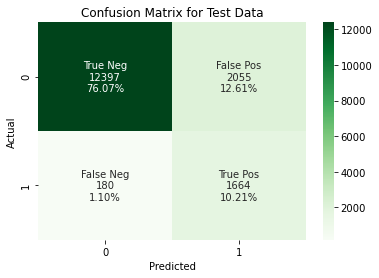

In [ ]:
y_train_pred, train_acc, tr_tn, tr_fp, tr_fn, tr_tp = print_confusion_matrix_accuracy(lgbm_meta_clf, D_meta_train, y_d2)

Model Accuracy:  0.865365733922435


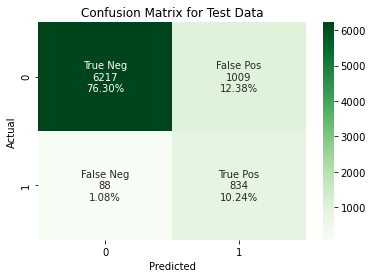

In [ ]:
y_test_pred, test_acc, te_tn, te_fp, te_fn, te_tp = print_confusion_matrix_accuracy(lgbm_meta_clf, D_meta_test, y_test)

In [ ]:
print("From the above confusion matrix, by targetting ", round(100 * (te_fp + te_tp) / (te_tn + te_fp + te_fn + te_tp)), "% of the leads, we can acheive ", \
      round((100 * te_tp) / (te_fn + te_tp)), "% of the conversion rate. ")

From the above confusion matrix, by targetting  23 % of the leads, we can acheive  90 % of the conversion rate. 


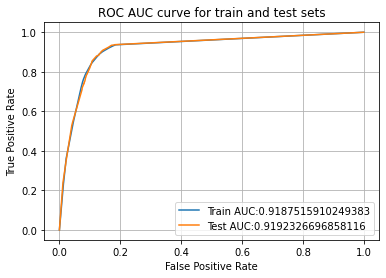

In [ ]:
y_train_pred_prob, y_test_pred_prob, train_auc, test_auc = plot_auc(lgbm_meta_clf, D_meta_train, D_meta_test, y_d2, y_test)

In [ ]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9860428231562253 and class-1:  0.4525230602278893
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8603653473567673 and class-1: 0.9045553145336226
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9189269085802972 and class-1: 0.6032549728752261


In [ ]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9383947939262473

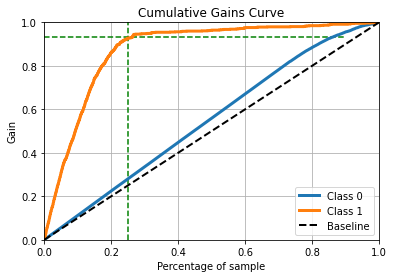

In [ ]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=lift_index)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 25% of the leads we can acheive 92.16% of the conversion rate.

In [ ]:
meta_metrics['LGBM'][k] = dict()
meta_metrics['LGBM'][k]['trainacc'] = train_acc
meta_metrics['LGBM'][k]['testacc'] = test_acc
meta_metrics['LGBM'][k]['trainauc'] = train_auc
meta_metrics['LGBM'][k]['testauc'] = test_auc
meta_metrics['LGBM'][k]['prec'] = prec
meta_metrics['LGBM'][k]['recal'] = rec
meta_metrics['LGBM'][k]['f1'] = f1
meta_metrics['LGBM'][k]['lift'] = lift_index
meta_metrics['LGBM'][k]['per'] = 25

### Meta Model - CatBoost

In [ ]:
cat_meta_clf = CatBoostClassifier(class_weights=[0.13, 0.87], random_state=10, silent=True)

cat_meta_clf.fit(D_meta_train, y_d2)

##### Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8476313205694649


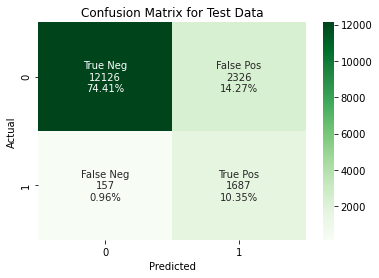

In [ ]:
y_train_pred, train_acc, tr_tn, tr_fp, tr_fn, tr_tp = print_confusion_matrix_accuracy(cat_meta_clf, D_meta_train, y_d2)

Model Accuracy:  0.8645066273932254


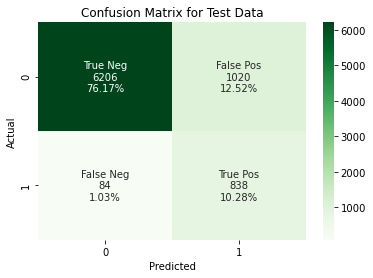

In [ ]:
y_test_pred, test_acc, te_tn, te_fp, te_fn, te_tp = print_confusion_matrix_accuracy(cat_meta_clf, D_meta_test, y_test)

In [ ]:
print("From the above confusion matrix, by targetting ", round(100 * (te_fp + te_tp) / (te_tn + te_fp + te_fn + te_tp)), "% of the leads, we can acheive ", \
      round((100 * te_tp) / (te_fn + te_tp)), "% of the conversion rate. ")

From the above confusion matrix, by targetting  25 % of the leads, we can acheive  92 % of the conversion rate. 


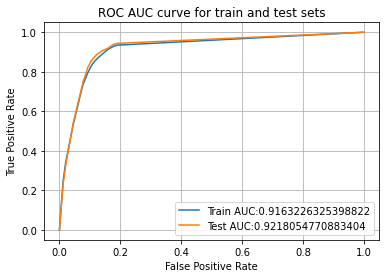

In [ ]:
y_train_pred_prob, y_test_pred_prob, train_auc, test_auc = plot_auc(cat_meta_clf, D_meta_train, D_meta_test, y_d2, y_test)

In [ ]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9879694358640871 and class-1:  0.4246369554331497
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8409908663160808 and class-1: 0.9197396963123644
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9085744187785003 and class-1: 0.5810208975676602


In [ ]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9213665943600867

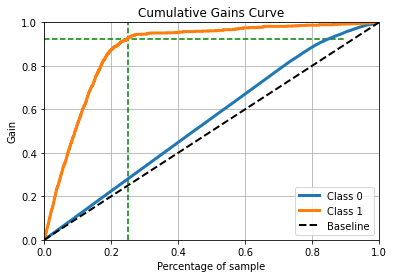

In [ ]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=lift_index)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 25% of the leads we can acheive 92.13% of the conversion rate.

In [ ]:
meta_metrics['CAT'][k] = dict()
meta_metrics['CAT'][k]['trainacc'] = train_acc
meta_metrics['CAT'][k]['testacc'] = test_acc
meta_metrics['CAT'][k]['trainauc'] = train_auc
meta_metrics['CAT'][k]['testauc'] = test_auc
meta_metrics['CAT'][k]['prec'] = prec
meta_metrics['CAT'][k]['recal'] = rec
meta_metrics['CAT'][k]['f1'] = f1
meta_metrics['CAT'][k]['lift'] = lift_index
meta_metrics['CAT'][k]['per'] = 25

### Summary

In [ ]:
from tabulate import tabulate
heads = ['Clf', 'K', 'Tr. Acc', 'Test Acc', 'Tr. AUC', 'Test AUC', \
         'Precision', 'Recall', 'F1', 'Lift Index', '%']

data_table = []
for clf in meta_metrics:
    for K in meta_metrics[clf]:
        data_table.append([clf, K, meta_metrics[clf][K]['trainacc'], meta_metrics[clf][K]['testacc'],
                       meta_metrics[clf][K]['trainauc'], meta_metrics[clf][K]['testauc'],
                       meta_metrics[clf][K]['prec'][1], meta_metrics[clf][K]['recal'][1], 
                       meta_metrics[clf][K]['f1'][1], meta_metrics[clf][K]['lift'], meta_metrics[clf][K]['per']])

print(tabulate(data_table, heads, tablefmt='orgtbl'))

| Clf   |   K |   Tr. Acc |   Test Acc |   Tr. AUC |   Test AUC |   Precision |   Recall |       F1 |   Lift Index |   % |
|-------+-----+-----------+------------+-----------+------------+-------------+----------+----------+--------------+-----|
| LGBM  |  50 |  0.847386 |   0.849902 |  0.916208 |   0.921974 |    0.424637 | 0.91974  | 0.581021 |     0.921692 |  25 |
| LGBM  | 100 |  0.846281 |   0.84487  |  0.918074 |   0.919045 |    0.416094 | 0.91974  | 0.572973 |     0.937744 |  26 |
| LGBM  | 150 |  0.864691 |   0.867452 |  0.918855 |   0.923294 |    0.456498 | 0.899132 | 0.605551 |     0.936117 |  26 |
| LGBM  | 200 |  0.852786 |   0.85162  |  0.91865  |   0.918682 |    0.427268 | 0.914317 | 0.582383 |     0.916377 |  24 |
| CAT   |  50 |  0.847631 |   0.849902 |  0.916323 |   0.921805 |    0.424637 | 0.91974  | 0.581021 |     0.921367 |  25 |
| CAT   | 100 |  0.863525 |   0.864507 |  0.918518 |   0.917216 |    0.451023 | 0.908894 | 0.602878 |     0.931887 |  26 |
| CAT   | 150 | 

* Above is the comparison table - Hyper parameter tuning for number of base learners  
    * Recall is highest at K = 50 for both LGBM and CatBoost models
    * Lift Index is highest at K = 100 and K = 150 in LGBM
    * There is no overfit in any of the models

* We can choose the LGBM with K = 100 as best model, we can acheive 93.7% conversion rate by targetting 26% of the total leads